# **Methylation Biomarkers for Predicting Cancer**

## **Dimensionality Reduction: Principal Component Anlaysis**

**Author:** Meg Hutch

**Date:** February 25, 2020

**Objective:** Reduce dimensionality of the gene methylation data. In this specific script, we will be processing the data that has ensured equal samples among classes.

**Note: Currently, I have blocked out the code involving the test set. I wil need to rerun this and project onto the test set once I get around to the final validaiton. For now, this will just create Principal Components from the training data. When I do get around to running the test set, I can check the PCA_Full.ipynb to ensure that everything is running correctly, but it should be as simple as unblocking any test set sepcific code below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

Load Training and testing sets processed in R

In [2]:
# Training set
mcTrain = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/Final_Datasets/mcTrain_x_ds_70_30.csv')
#mcTest = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/Final_Datasets/mcTrain_x_ds_70_30.csv')

**Data Pre-Processing**

Check if any missing values: Nope!

In [3]:
mcTrain.columns[mcTrain.isna().any()].tolist()

[]

## **Principal Component Analysis**

We will first conduct dimensionality reduction using principal component analysis

First, subset the training set to only include the methylated gene information

In [4]:
# remove non-gene data from both the training and testing sets
genesTrain = mcTrain.drop(columns=["dilute_library_concentration", "age", "gender", "frag_mean"])
#genesTest = mcTest.drop(columns=["dilute_library_concentration", "age", "gender", "frag_mean"])

Create patient seq_num id index

In [5]:
## Training set
# Convert patinet_ids to row names 
genesTrain = genesTrain.set_index(genesTrain.id)

# Remove seq_num as a column
genesTrain = genesTrain.drop(columns=["id"])

# Create a list of row names
patients = list(genesTrain.index)

## Testing set
# Convert patinet_ids to row names 
#genesTest = genesTest.set_index(genesTest.id)

# Remove seq_num as a column
#genesTest = genesTest.drop(columns=["id"])

# Create a list of row names
#patientsTest = list(genesTest.index)

# **1) Standardize Dataset**

We will scale the data prior to performing PCA on the training set. 

**StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [6]:
# pca packages
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genesTrain.astype(np.float)) # no errors  

In [7]:
# manual check that the StandardScaler().fit_transform is correctly scaling the data - look good - 
#genesTrain.head()
#np.mean(genesTrain['OR4F5'])
#np.std(genesTrain['OR4F5'])

#np.mean(genesTrain['AL627309.1'])
#np.std(genesTrain['AL627309.1'])

**Check whether the normalized data has a mean of zero and a standard deviation of 1:**

In [8]:
np.mean(x), np.std(x)

(-3.4533935196480224e-18, 0.9610476395293968)

**Standardize the Test Set**

To standardize each column of the test set, we need to subtract the mean of the training data and then divide by the standard deviation of the training data.

In [9]:
# Functions to calculate mean and sd of each column 
genesTrain_mean = genesTrain.mean()
genesTrain_sd = genesTrain.std()

Transpose the mean and sd datasets in order to faciliate the calculations with the testing sets

The below code functions to take the mean (or sd) of all the genes (one row) and then duplicates that row. Thus, later on, we can take those dataframes and just subtract each mean or sd from the test set

In [10]:
# Transpose the mean dataset
genesTrain_mean = pd.DataFrame(genesTrain_mean)
genesTrain_mean = genesTrain_mean.transpose()

# add duplicated rows to match the number of rows in the test set (100 samples) - this will faciliate the subtraction and standard deviation division
genesTrain_mean = pd.concat([genesTrain_mean]*100)

# Transpose the sd dataset
genesTrain_sd = pd.DataFrame(genesTrain_sd)
genesTrain_sd = genesTrain_sd.transpose()

# Add duplicated rows to the sd dataset
genesTrain_sd = pd.concat([genesTrain_sd]*100)

In [11]:
# remove index
#genesTest.reset_index(level=0, inplace=True)
# Drop seq_num column
#genesTest = genesTest.drop(columns=["id"])

**Replace 0s with 0.01 in order to not get NA values -  is this kosher?**

In [12]:
genesTrain_sd = genesTrain_sd.replace(0, 0.0000000001)

**Subtract each value in the Test set by the training set mean and divide by the training set standard deviation**

In [13]:
# Subtract the mean values from the genesTest
#genesTest = pd.DataFrame(genesTest.values-genesTrain_mean.values, columns=genesTest.columns)

# Divide the trained mean subtracted values by standard deviation of the training set
#genesTest = pd.DataFrame(genesTest.values/genesTrain_sd.values, columns=genesTest.columns)

**Remove any genes that have NAs**

Because we converted 0s to a smaller number, none of these are NAs

In [14]:
#genesTest = genesTest.dropna(axis = 1) # by indicating axis = 1, we are able to drop any genes that have become NAs === are we still have to perform PCA now? 

**Convert the normalized features into tabular format**

In [15]:
# Create list of column names
features = list(genesTrain.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

# **2) Determine Prinicpal Components**

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimensionality of your data.

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [16]:
## Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 213)] # there are 212 samples - so we want to have range of 1 less than 213 column names 

# Add column names to the principal component dataset 
principalDf_ALL = pd.DataFrame(principalComponents, columns = col_names, index = patients)

**3) Determine # of Components and Variance**

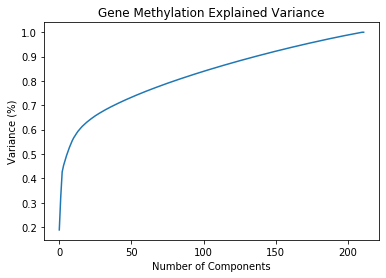

In [17]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Methylation Explained Variance')
plt.savefig('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/04_Results/PC_%Variance_DS_Data.png')
plt.show()

**Alternative method - Pre-selecting % of variance**

When we fit the PCA classifier and transform x after specifying 90%, we get 137 principal components representing 90% of the variance.

In [18]:
pca = PCA(0.9)
genesTrain_transformed = pca.fit_transform(x)

pca.n_components_ 

137

**Define PC column names and create dataframe**

In [19]:
# Define new pc column names (up to pc137)
col_names = [f'pc{i}' for i in range(1, 138)] 

# Add column names to the principal component dataset 
genesTrain_transformed = pd.DataFrame(genesTrain_transformed, columns = col_names, index = patients)

**Scree Plot**

View which principal components contribute most to the variance 

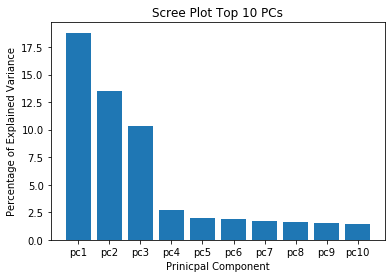

In [20]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot Top 10 PCs')
plt.savefig('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/04_Results/PCA_Screeplot_DS_Data.png')
plt.show()

# **4) Project prinicipal components onto the test set**

**Need to eventually run on test set**

In [21]:
#genesTest_transformed = pca.transform(genesTest)

When converted to a dataframe, we can see that the test set has been transformed into 157 principal components

In [22]:
#genesTest_transformed = pd.DataFrame(data = genesTest_transformed, columns = col_names, index = patientsTest)
#genesTest_transformed

# **5) Save PCA Components**

In [23]:
genesTrain_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/Final_Datasets/pca_train_DS_70_30.csv')
#genesTest_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/Final_Datasets/pca_test_DS_70_30.csv')